# Lab 1 for Decision-Making Theory

The goal of this lab is to get acquainted with the basics of decision-making in multi-criteria selection problems using the concept of optimality according to the Pareto principle and the Slater one.

In [436]:
import matplotlib.pyplot as plt
import pandas as pd
import typing as tp

In [437]:
pd.set_option('display.max_columns', 60)

## Implementation of the Pareto and Slater principles

The following blocks of code implement the Pareto and Slater principles respectively for a maximization problem.

In [438]:
def is_dominated_by_pareto_maximization(s1: tp.Iterable, s2: tp.Iterable):
    """
    Returns True if solution s1 is dominated by solution s2, False otherwise.
    """
    return all(x1 <= x2 for x1, x2 in zip(s1, s2)) and any(x1 < x2 for x1, x2 in zip(s1, s2))

def is_dominated_by_slater_maximization(s1: tp.Iterable, s2: tp.Iterable):
    """
    Returns True if solution s1 is dominated by solution s2, False otherwise.
    """
    return all(x1 < x2 for x1, x2 in zip(s1, s2))

These ones implement the Pareto and Slater principles respectively for a maximization problem.

In [439]:
def is_dominated_by_pareto_minimization(s1: tp.Iterable, s2: tp.Iterable):
    """
    Returns True if solution s1 is dominated by solution s2, False otherwise.
    """
    return all(x1 >= x2 for x1, x2 in zip(s1, s2)) and any(x1 > x2 for x1, x2 in zip(s1, s2))

def is_dominated_by_slater_minimization(s1: tp.Iterable, s2: tp.Iterable):
    """
    Returns True if solution s1 is dominated by solution s2, False otherwise.
    """
    return all(x1 > x2 for x1, x2 in zip(s1, s2))

And this one is where all the magic happens. This is the function which allows us to get all the information we need to make a decision: an optimal pool of alternatives and the data about which one dominates another.

The latter is needed to build a table with all the information about the alternatives and their dominance relations so that we can look at the results without glancing at different tables and trying to compare them.

In [440]:
def get_optimal_set(input_dict: dict[str, tp.Iterable[tuple]], comparator_func: tp.Callable[[tp.Iterable, tp.Iterable], bool] = is_dominated_by_pareto_maximization) -> dict[tp.Literal["optimal", "domination"], dict[str, tp.Iterable[tuple]]]:
    """
    Returns the (by default, maximization by Pareto) optimal solution set for a given solution set.
    """
    optimal_set = {}
    domination_set = input_dict.copy()
    input_dict_items = input_dict.items()

    for key1, s1 in input_dict_items:
        if s1 in domination_set:
            continue

        is_dominated = False
        dominated_by = ""

        for key2, s2 in input_dict_items:
            if key1 == key2 or s2 in domination_set:
                continue

            if comparator_func(s1, s2):
                is_dominated = True
                dominated_by = key2

                break

        if not is_dominated:
            optimal_set.update({key1: s1})
            domination_set.update({key1: (*s1, "")})
        else:
            domination_set.update({key1: (*s1, dominated_by)})

        is_dominated = False
        dominated_by = ""

    return {
        "optimal": optimal_set,
        "domination": domination_set
    }

The following blocks of code don't relate to the implementation of the principles, but they are needed to do all the service stuff like reading files, parse the data, build graphics etc.

<div class="alert alert-block alert-info">
  If needed, feel free to read a more detailed description of the functions' code in the comments
</div>

In [441]:
def split_numbers_list_into_digits_list(numbers_list: list[list[int]]):
    """
    Splits a list of numbers into a list of digits.
    """
    return [[int(d) for d in str(num)] for num in numbers_list]

def convert_list_to_tuples_dict(numbers_list: list[list[int]], keys: list[str]):
    """
    Converts a list of numbers into a list of tuples.
    """
    return {key: tuple(digits) for key, digits in zip(keys, numbers_list)}

def parse_numbers_to_tuples_dict(numbers_list: list[list[int]], keys: list[str]):
    """
    Parses a list of numbers to a dict of tuples of digits of corresponding number.
    """
    digits_list = split_numbers_list_into_digits_list(numbers_list)
    max_len = max(len(digits) for digits in digits_list)
    padded_digits_list = prepend_digits_list_items_with(digits_list, max_len)

    return convert_list_to_tuples_dict(padded_digits_list, keys)

def prepend_digits_list_items_with(digits_list: list[list[int]], max_len, pad_value=0):
    """
    Pads each list of digits in a list with a pad value so that they all have the same length,
    and then prepends the pad value to the beginning of each list of digits.
    """
    padded_list = [[pad_value] * (max_len - len(digits)) for digits in digits_list]
    padded_digits_list = [padded + digits for padded, digits in zip(padded_list, digits_list)]

    return padded_digits_list

In [442]:
def read_data_frame_from_csv(file_path: str, custom_column_names: list = None) -> pd.DataFrame:
  """
  Reads a data frame from a csv file.
  """
  return pd.read_csv(file_path, names=custom_column_names)

def get_data_frame_row(data_frame: pd.DataFrame, row_index: int) -> pd.Series:
  """
  Returns a row of a data frame as a list.
  """
  return data_frame.iloc[row_index]

def get_num_elements_in_row(df: pd.DataFrame, row_index: int) -> int:
  """
  Returns the number of elements in a row of a Pandas DataFrame.
  """
  return len(get_data_frame_row(df, row_index))

def get_num_rows(df: pd.DataFrame) -> int:
  """
  Returns the number of rows in a Pandas DataFrame.
  """
  return df.shape[0]

In [443]:
def plot_2d_frontier(full_list: list[tuple[int, int]], optimal_list: list[tuple[int, int]], dots_labels: list[str], title: str, is_minimized: bool = False):
    x = [dot[0] for dot in full_list]
    y = [dot[1] for dot in full_list]

    sorted_list = sorted(optimal_list, key=lambda dot: (dot[0], -dot[1]) if is_minimized else (-dot[0], dot[1]))
    xLine = [dot[0] for dot in sorted_list]
    yLine = [dot[1] for dot in sorted_list]

    _, ax = plt.subplots(figsize=(10, 10))

    for i, label in enumerate(dots_labels):
        dy = -0.2 if i % 2 == 0 else 0.2  # Add a small offset to the y coordinate of the caption
        ax.text(x[i], y[i] + dy, label)

    ax.set_xlim(-0.05, max(x) + 0.5)
    ax.set_xticks(range(0, max(x) + 1, 1))
    ax.set_ylim(-0.05, max(y) + 0.5)
    ax.set_yticks(range(0, max(y) + 1, 1))
    ax.scatter(x, y)

    ax.plot(xLine, yLine, c='black', linewidth=2)

    ax.set_xlabel('Q1')
    ax.set_ylabel('Q2')
    ax.set_title(title)

    ax.grid(True)

    plt.show()

In [444]:
def create_dict_from_list_of_tuples(list_of_tuples: list[tuple], keys: list[str]) -> dict:
    """
    Creates a dictionary from a list of tuples with specified keys.
    """
    return {keys[i]: t for i, t in enumerate(list_of_tuples)}

In [445]:
def create_table_from(data: dict[str, tuple], row_names: list[str]):
    """
    Builds a table from a list of tuples.
    """

    table = pd.DataFrame(data, index=row_names)

    return table

In [446]:
def create_names_list(num_elements: int, name: str) -> list[str]:
    """
    Creates a list of names of specified length.
    """
    return [f'{name}{i + 1}' for i in range(num_elements)]

In [447]:
def merge_results(full_set_pareto: dict[str, tp.Iterable[tuple]], full_set_slater: dict[str, tp.Iterable[tuple]]) -> dict[str, tp.Iterable[tuple]]:
    """
    Merges the results of Pareto and Slater optimality.
    """
    merged_results = full_set_pareto.copy()

    for key, value in merged_results.items():
        merged_results.update({
            key: (*value, full_set_slater[key][2])
        })

    return merged_results

In [448]:
def solve_task(file_path: str, is_minimized: bool = False):
    """
    Solves the task.
    """
    identifier = file_path.split(".")[0] + ("-min" if is_minimized else "-max")

    df = read_data_frame_from_csv(file_path)
    rows_num = get_num_rows(df)
    columns_names = df.columns.tolist()

    is_dominated_by_pareto = is_dominated_by_pareto_minimization if is_minimized else is_dominated_by_pareto_maximization
    is_dominated_by_slater = is_dominated_by_slater_minimization if is_minimized else is_dominated_by_slater_maximization

    for row_index in range(rows_num):
        print(f"(Row #{row_index + 1}) Result:")

        row = get_data_frame_row(df, row_index).tolist()
        full_list = parse_numbers_to_tuples_dict(row, columns_names)
        tuple_len = len(full_list[columns_names[0]])
        row_names = create_names_list(tuple_len, 'Q')

        answer_for_pareto = get_optimal_set(full_list, is_dominated_by_pareto)
        optimal_set_by_pareto, dominated_alts_set_by_pareto = answer_for_pareto["optimal"], answer_for_pareto["domination"]

        answer_for_slater = get_optimal_set(full_list, is_dominated_by_slater)
        optimal_set_by_slater, dominated_alts_set_by_slater = answer_for_slater["optimal"], answer_for_slater["domination"]

        merged_results = merge_results(dominated_alts_set_by_pareto, dominated_alts_set_by_slater)
        table = create_table_from(merged_results, row_names + ["Dominated by (Pareto)", "Dominated by (Slater)"])

        print(table)
        table.to_csv(f"{identifier}-row-{row_index + 1}.csv")

        plot_2d_frontier(full_list.values(), optimal_set_by_pareto.values(), columns_names, f"(Row #{row_index + 1}) Pareto frontier", is_minimized)
        plot_2d_frontier(full_list.values(), optimal_set_by_slater.values(), columns_names, f"(Row #{row_index + 1}) Slater frontier", is_minimized)

<div class="alert alert-block alert-info">
  These are the solutions to maximization problems. You can examine the created tables and the graphical representation of them.
</div>

(Row #1) Result:
                        A1   A2 A3   A4  A5  A6   A7   A8  A9  A10 A11  A12  \
Q1                       6    5  9    5   3   0    7    6   3    8   8    7   
Q2                       3    5  0    8   0   4    1    1   3    5   9    3   
Dominated by (Pareto)  A10   A4     A11  A1  A2  A10   A1  A1  A11      A10   
Dominated by (Slater)  A10  A11     A11  A1  A2  A10  A10  A2           A10   

                      A13 A14 A15 A16  A17 A18  A19 A20  
Q1                      0   5   0   5    6   0    8   0  
Q2                      4   1   5   0    8   3    5   6  
Dominated by (Pareto)  A2  A1  A2  A1  A11  A1  A11  A4  
Dominated by (Slater)  A2  A1  A4  A1  A11  A2       A4  


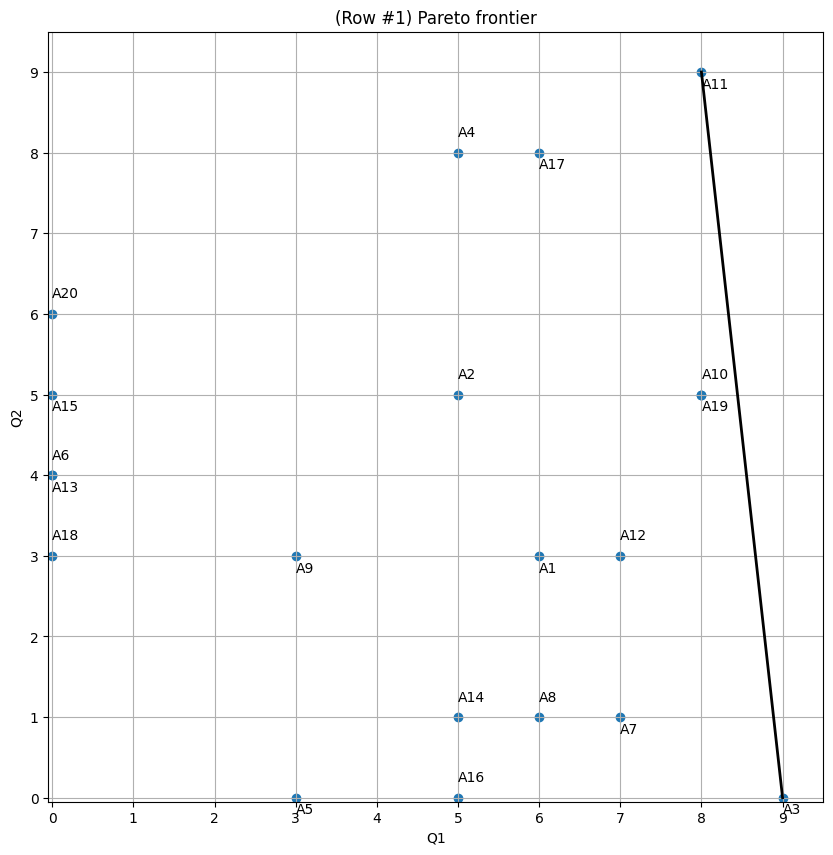

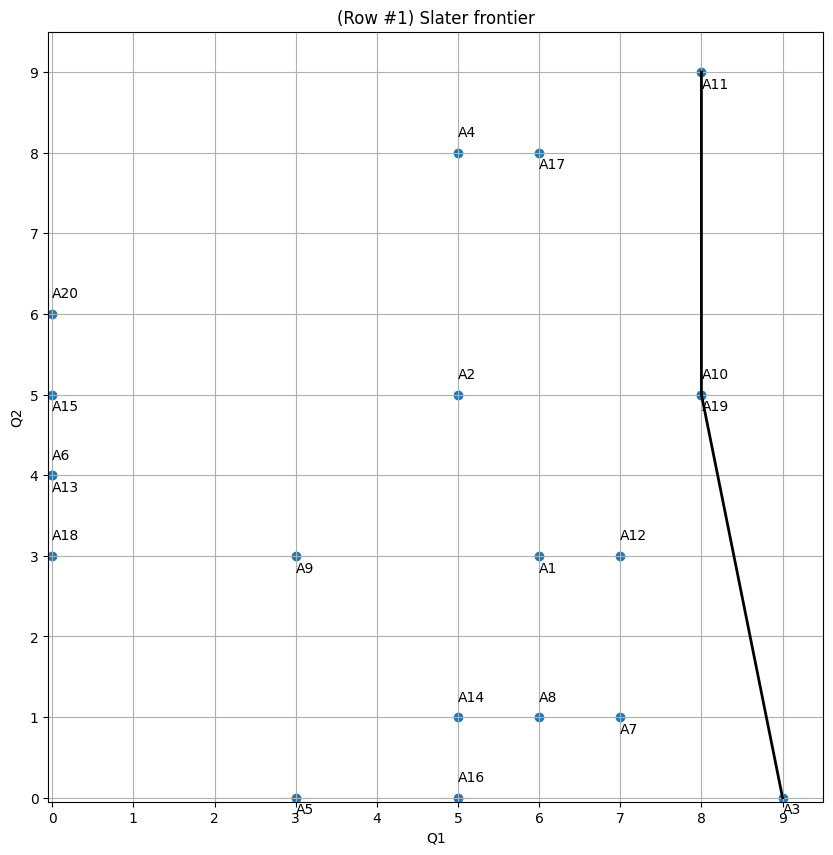

(Row #2) Result:
                       A1  A2 A3  A4  A5  A6  A7 A8 A9 A10 A11 A12 A13 A14  \
Q1                      9   3  4   2   6   2   6  7  9   8   6   6   3   5   
Q2                      5   9  9   0   7   6   3  7  6   1   5   0   6   5   
Dominated by (Pareto)  A9  A3     A1  A8  A2  A1        A1  A1  A1  A2  A1   
Dominated by (Slater)             A1      A2  A1        A1  A8  A1  A3  A5   

                      A15 A16 A17 A18 A19 A20  
Q1                      7   1   1   4   3   9  
Q2                      0   8   1   2   2   6  
Dominated by (Pareto)  A1  A2  A1  A1  A1      
Dominated by (Slater)  A1  A2  A1  A1  A1      


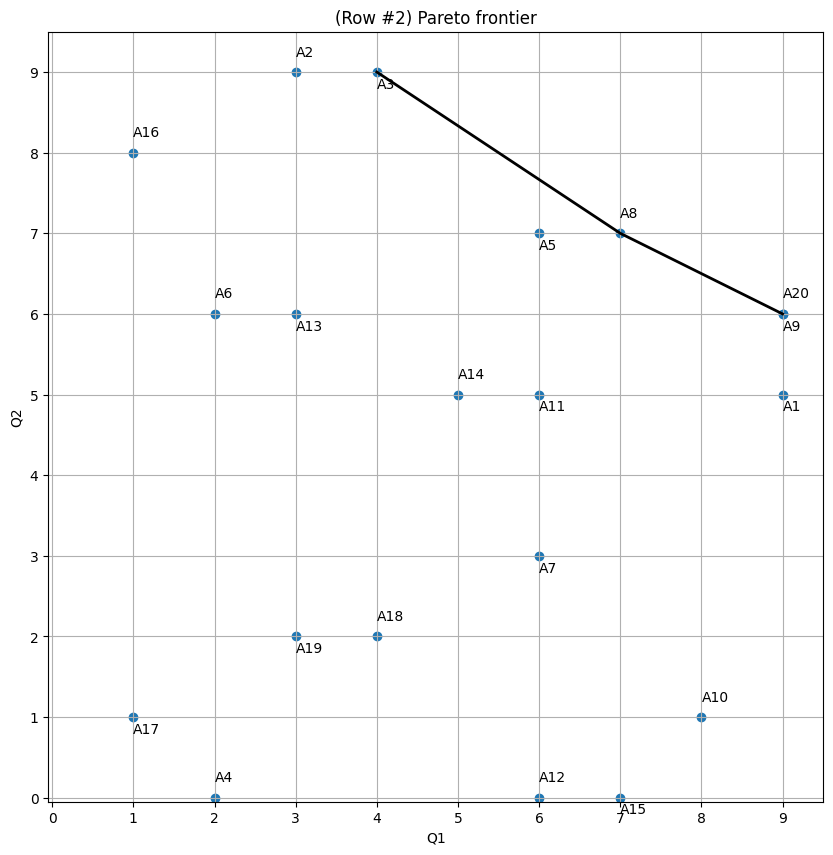

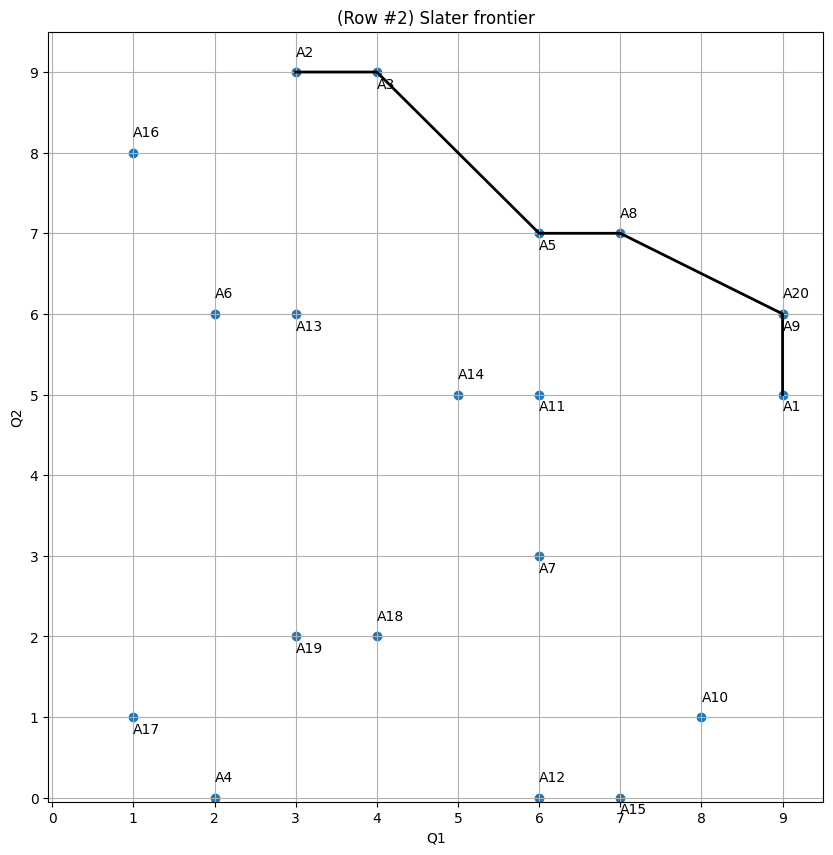

(Row #3) Result:
                      A1  A2  A3   A4  A5  A6  A7  A8   A9 A10 A11 A12 A13  \
Q1                     7   2   7    8   7   2   3   4    8   7   9   3   6   
Q2                     9   1   0    4   2   7   4   0    3   2   8   0   3   
Dominated by (Pareto)     A1  A1  A11  A1  A1  A1  A1   A4  A1      A1  A1   
Dominated by (Slater)     A1  A4  A11  A4  A1  A1  A1  A11  A4      A1  A1   

                      A14 A15 A16 A17 A18 A19 A20  
Q1                      4   5   3   7   1   5   2  
Q2                      7   0   0   3   4   9   2  
Dominated by (Pareto)  A1  A1  A1  A1  A1  A1  A1  
Dominated by (Slater)  A1  A1  A1  A4  A1      A1  


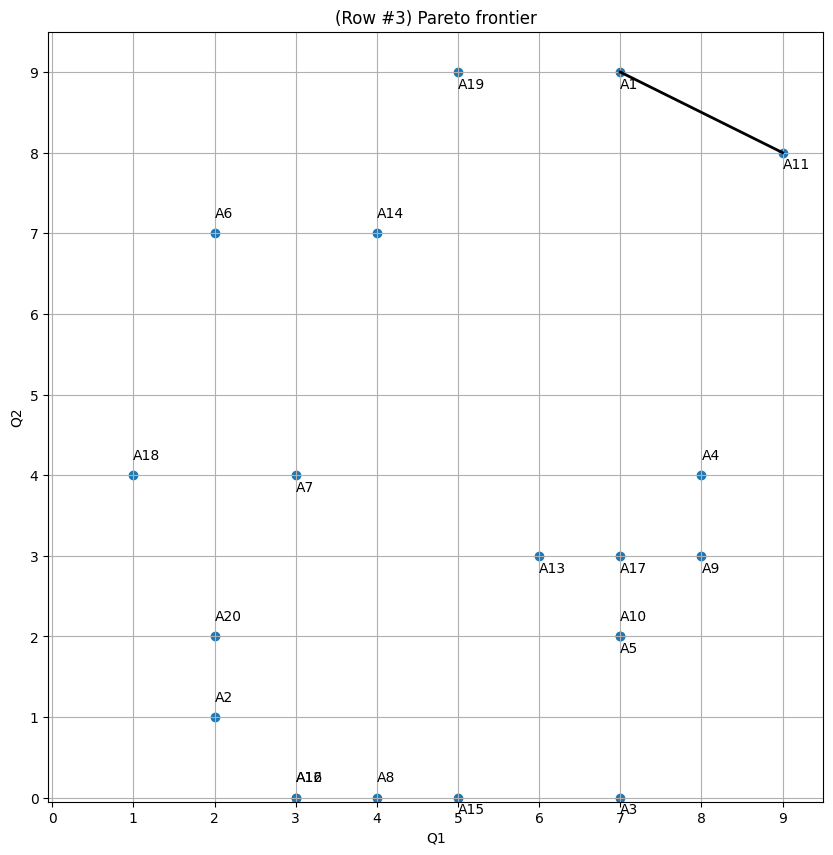

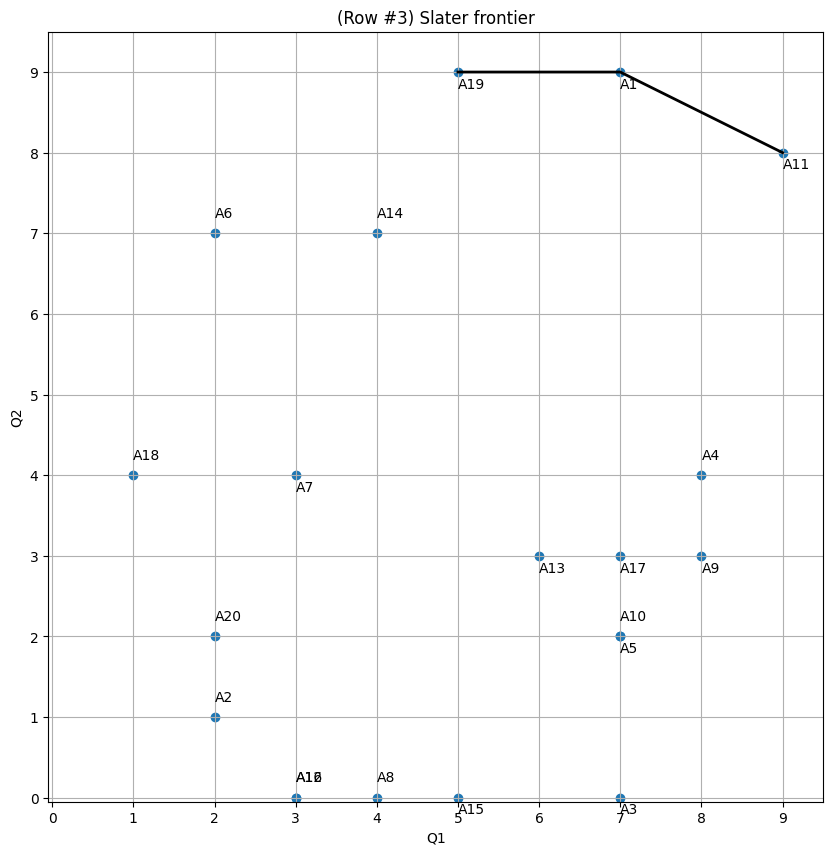

In [449]:
solve_task('original.csv')

This one is the merged rows from the previous tasks. It is also the maxizimation one.

(Row #1) Result:
                        A1   A2   A3   A4  A5  A6   A7   A8  A9  A10 A11  A12  \
Q1                       6    5    9    5   3   0    7    6   3    8   8    7   
Q2                       3    5    0    8   0   4    1    1   3    5   9    3   
Dominated by (Pareto)  A10   A4  A21  A11  A1  A2  A10   A1  A1  A11      A10   
Dominated by (Slater)  A10  A11       A11  A1  A2  A10  A10  A2  A29      A10   

                      A13 A14 A15 A16  A17 A18  A19 A20  A21  A22  A23 A24  \
Q1                      0   5   0   5    6   0    8   0    9    3    4   2   
Q2                      4   1   5   0    8   3    5   6    5    9    9   0   
Dominated by (Pareto)  A2  A1  A2  A1  A11  A1  A11  A4  A29  A11  A11  A1   
Dominated by (Slater)  A2  A1  A4  A1  A11  A2  A29  A4                 A1   

                       A25 A26  A27  A28  A29  A30  A31 A32 A33  A34  A35  \
Q1                       6   2    6    7    9    8    6   6   3    5    7   
Q2                       7   6  

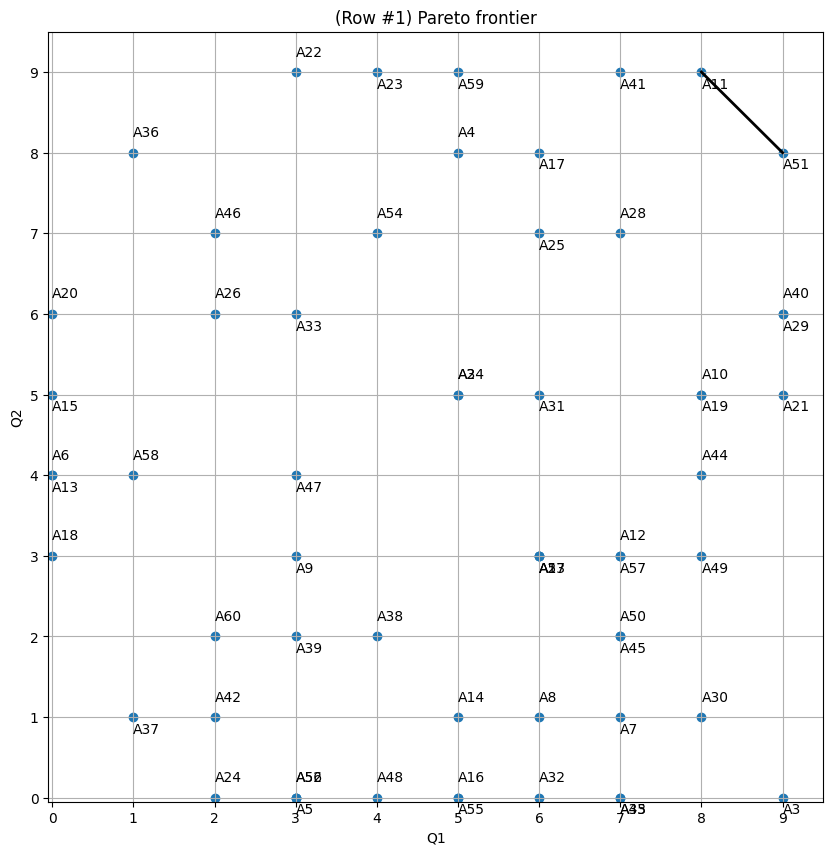

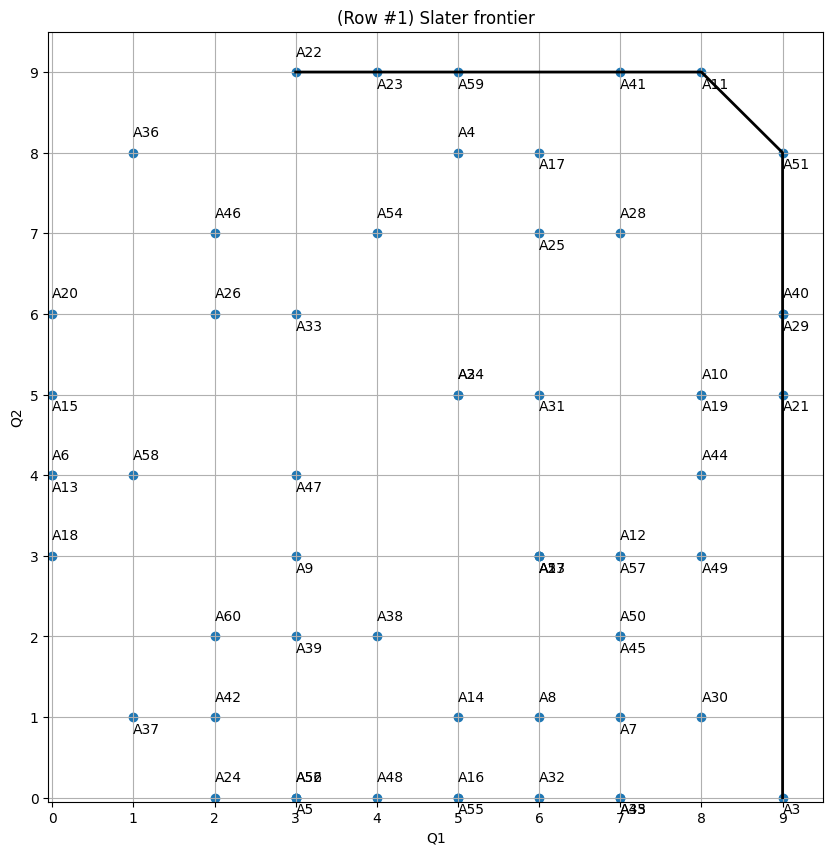

In [450]:
solve_task('original-long.csv')

<div class="alert alert-block alert-info">
  These are the solutions to minimization problems. You can examine the created tables and the graphical representation of them.
</div>

(Row #1) Result:
                       A1  A2  A3  A4 A5   A6  A7  A8  A9 A10 A11 A12  A13  \
Q1                      6   5   9   5  3    0   7   6   3   8   8   7    0   
Q2                      3   5   0   8  0    4   1   1   3   5   9   3    4   
Dominated by (Pareto)  A5  A5  A5  A2     A18  A5  A5  A5  A1  A1  A1  A18   
Dominated by (Slater)  A5  A5      A5          A5  A5      A1  A1  A5        

                      A14 A15 A16 A17 A18 A19 A20  
Q1                      5   0   5   6   0   8   0  
Q2                      1   5   0   8   3   5   6  
Dominated by (Pareto)  A5  A6  A5  A1      A1  A6  
Dominated by (Slater)  A5          A2      A1      


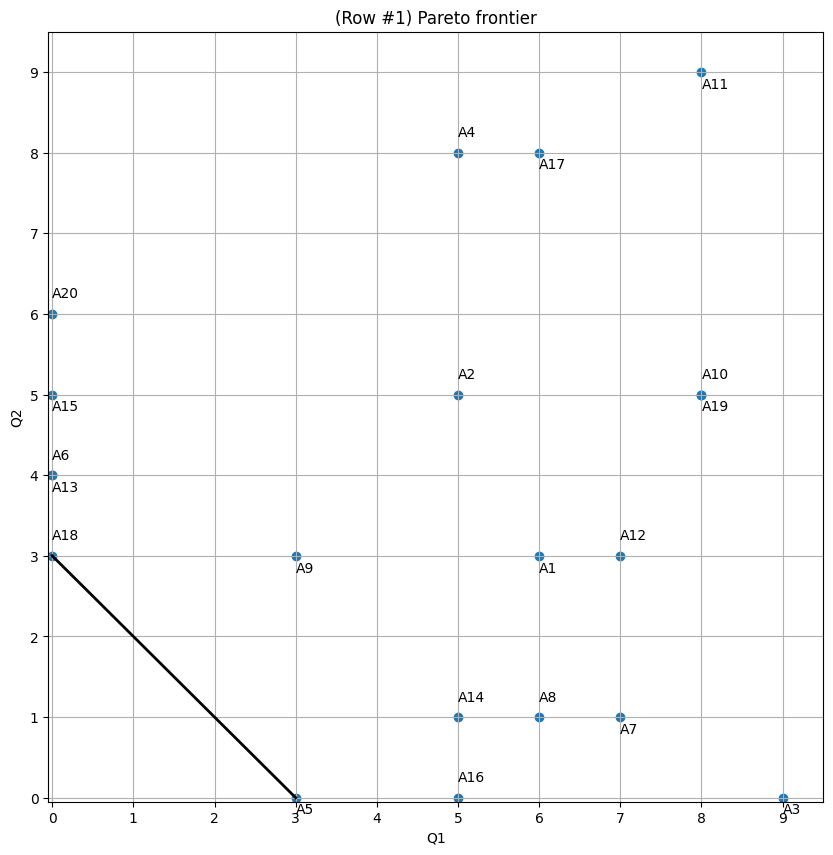

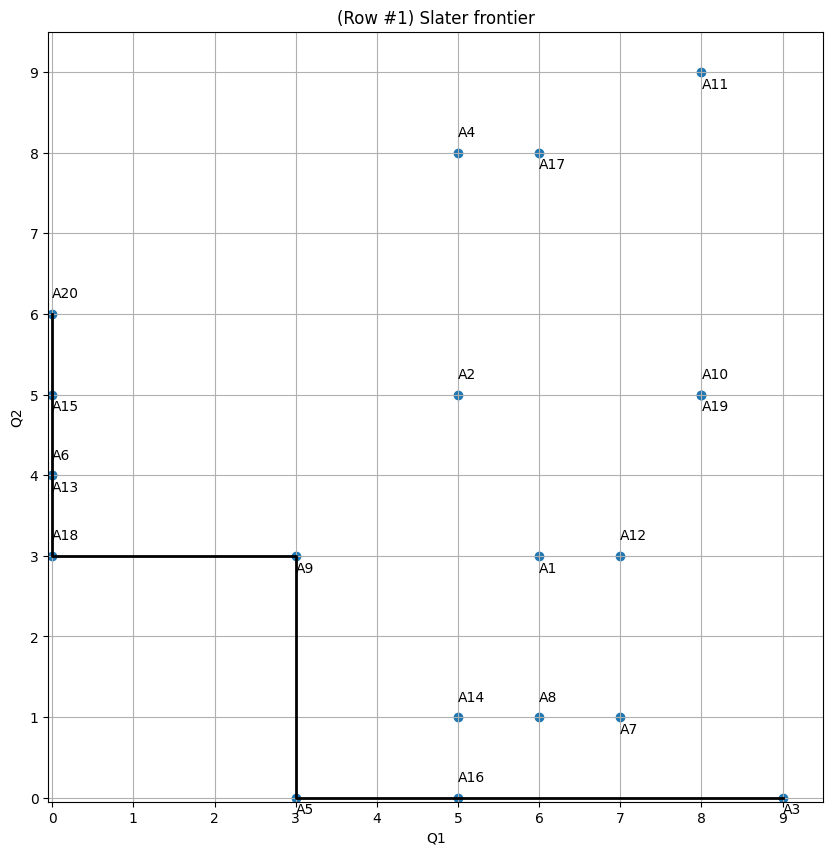

(Row #2) Result:
                       A1  A2  A3 A4  A5   A6  A7  A8  A9 A10 A11 A12 A13 A14  \
Q1                      9   3   4  2   6    2   6   7   9   8   6   6   3   5   
Q2                      5   9   9  0   7    6   3   7   6   1   5   0   6   5   
Dominated by (Pareto)  A4  A4  A2     A4   A4  A4  A4  A1  A4  A4  A4  A4  A4   
Dominated by (Slater)  A4  A4  A4     A4  A17  A4  A4  A4  A4  A4      A4  A4   

                      A15  A16 A17 A18 A19 A20  
Q1                      7    1   1   4   3   9  
Q2                      0    8   1   2   2   6  
Dominated by (Pareto)  A4  A17      A4  A4  A1  
Dominated by (Slater)               A4  A4  A4  


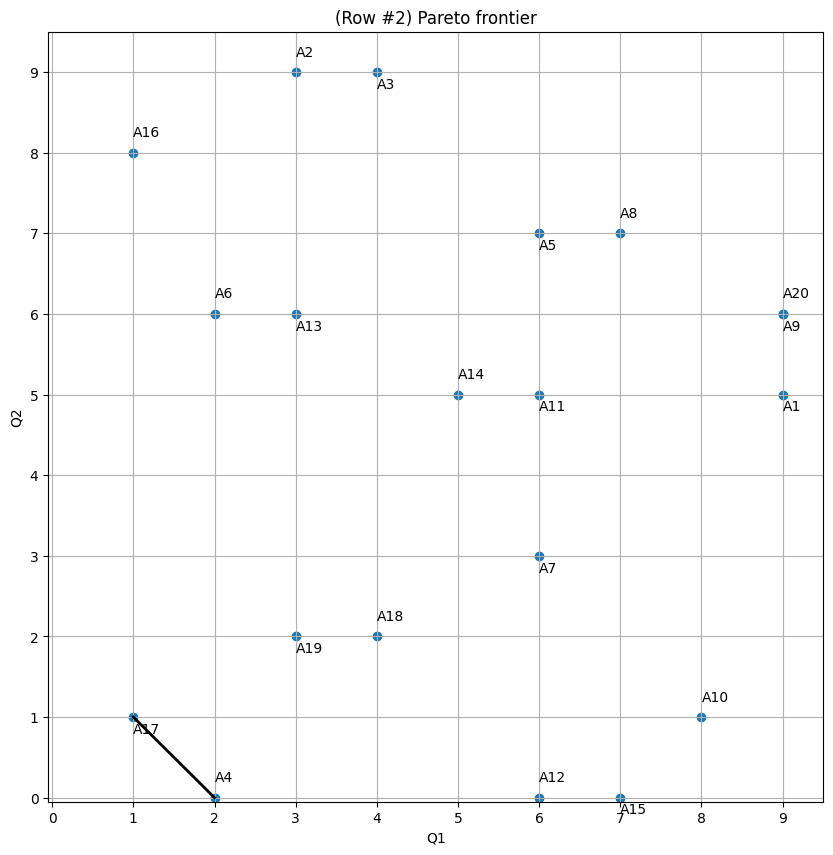

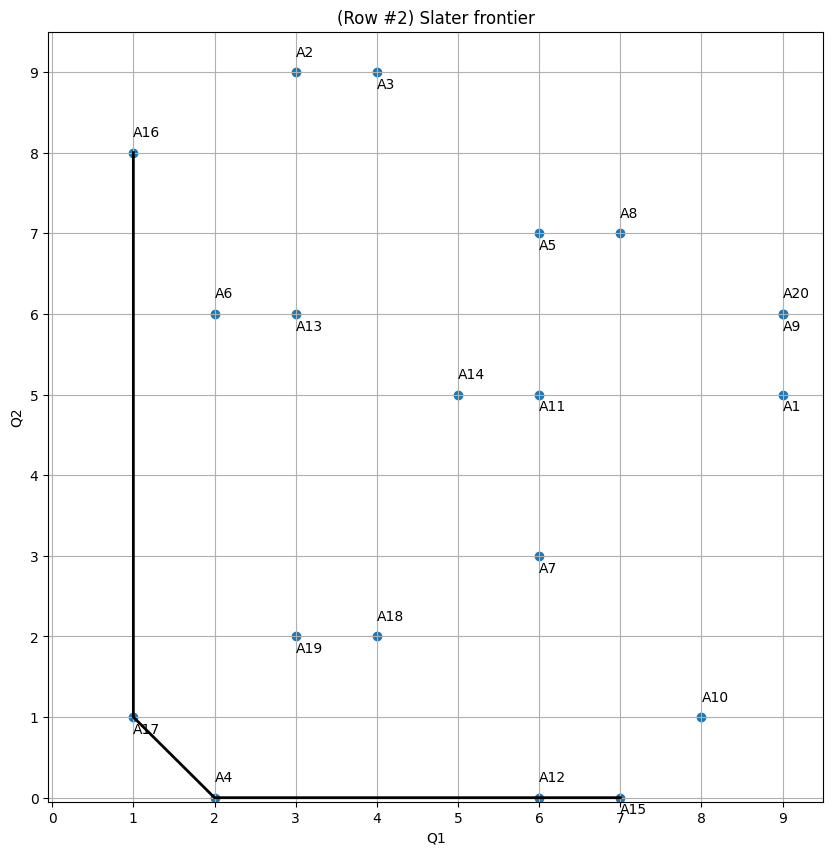

(Row #3) Result:
                       A1 A2  A3  A4  A5   A6  A7   A8  A9 A10 A11 A12 A13  \
Q1                      7  2   7   8   7    2   3    4   8   7   9   3   6   
Q2                      9  1   0   4   2    7   4    0   3   2   8   0   3   
Dominated by (Pareto)  A2     A8  A2  A2   A2  A2  A12  A2  A2  A2      A2   
Dominated by (Slater)  A2         A2  A2  A18  A2       A2  A2  A2      A2   

                      A14 A15 A16 A17 A18 A19 A20  
Q1                      4   5   3   7   1   5   2  
Q2                      7   0   0   3   4   9   2  
Dominated by (Pareto)  A2  A8      A2      A2  A2  
Dominated by (Slater)  A2          A2      A2      


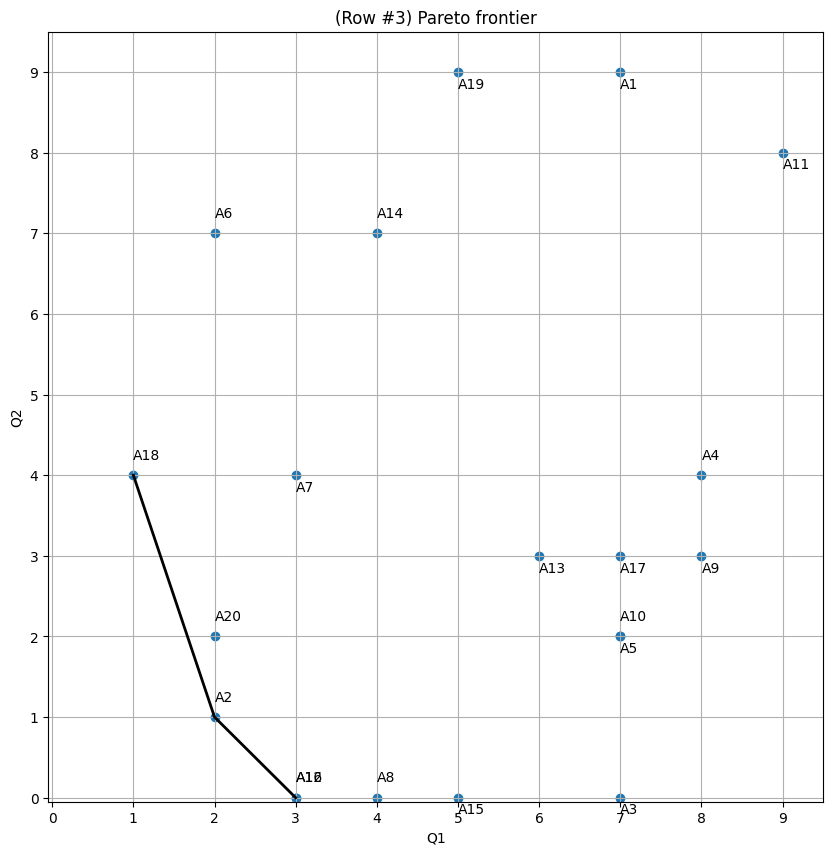

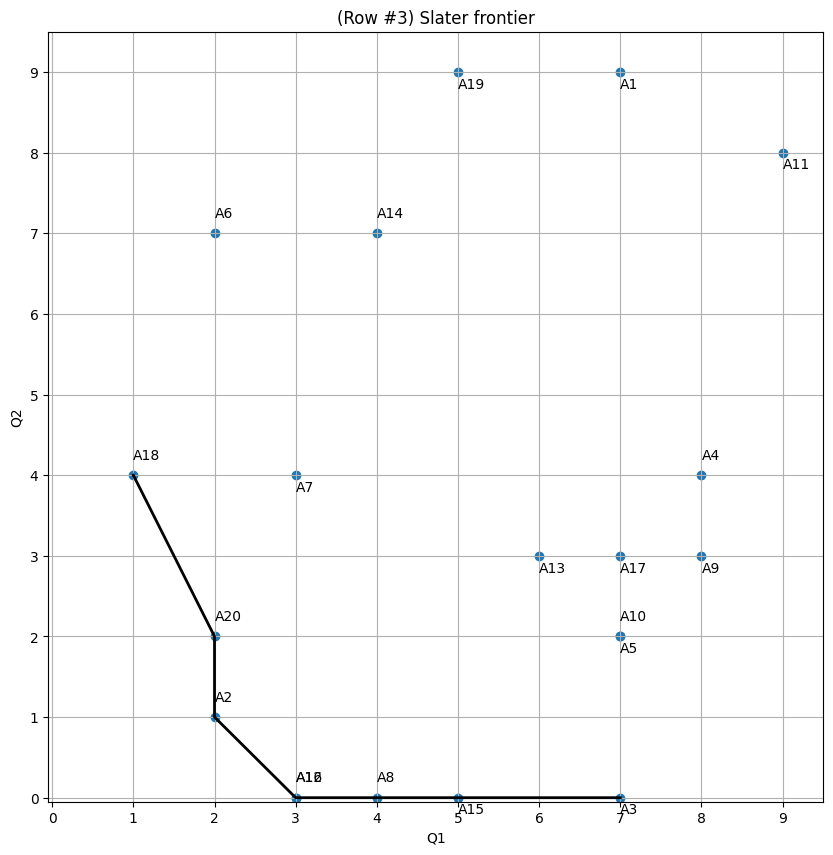

In [451]:
solve_task('original.csv', is_minimized=True)

(Row #1) Result:
                       A1  A2  A3  A4   A5   A6  A7  A8   A9 A10 A11 A12  A13  \
Q1                      6   5   9   5    3    0   7   6    3   8   8   7    0   
Q2                      3   5   0   8    0    4   1   1    3   5   9   3    4   
Dominated by (Pareto)  A5  A5  A5  A2  A24  A18  A5  A5   A5  A1  A1  A1  A18   
Dominated by (Slater)  A5  A5      A5            A5  A5  A24  A1  A1  A5        

                      A14 A15 A16 A17 A18 A19 A20 A21 A22 A23 A24 A25 A26 A27  \
Q1                      5   0   5   6   0   8   0   9   3   4   2   6   2   6   
Q2                      1   5   0   8   3   5   6   5   9   9   0   7   6   3   
Dominated by (Pareto)  A5  A6  A5  A1      A1  A6  A1  A5  A5      A1  A6  A5   
Dominated by (Slater)  A5          A2      A1      A1  A6  A5      A2  A6  A5   

                      A28 A29 A30 A31 A32 A33 A34 A35 A36 A37 A38  A39 A40  \
Q1                      7   9   8   6   6   3   5   7   1   1   4    3   9   
Q2             

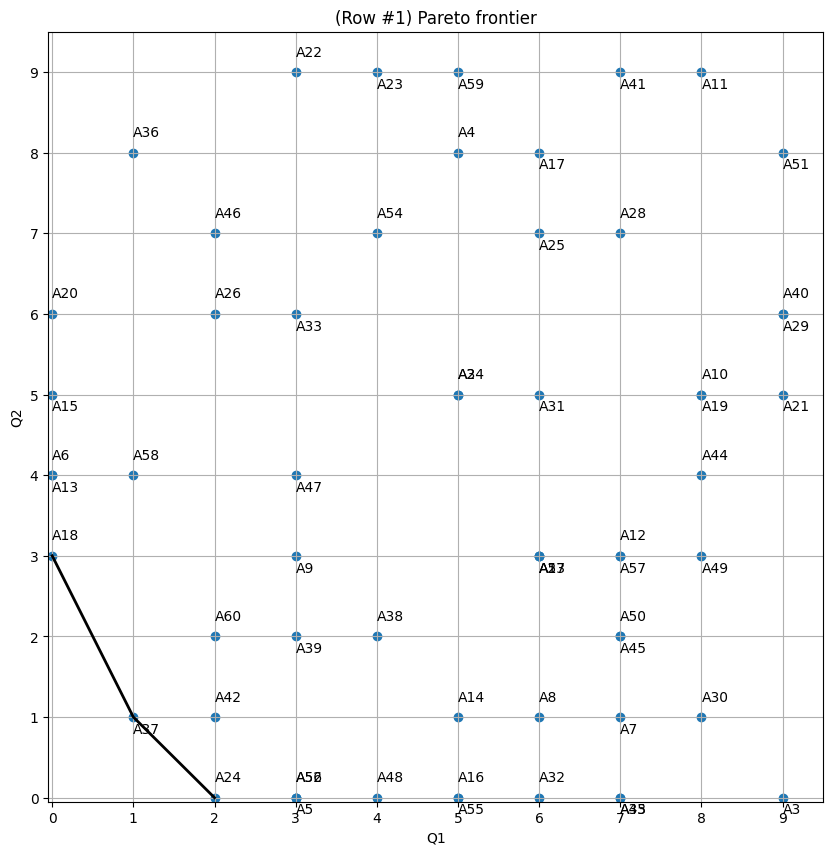

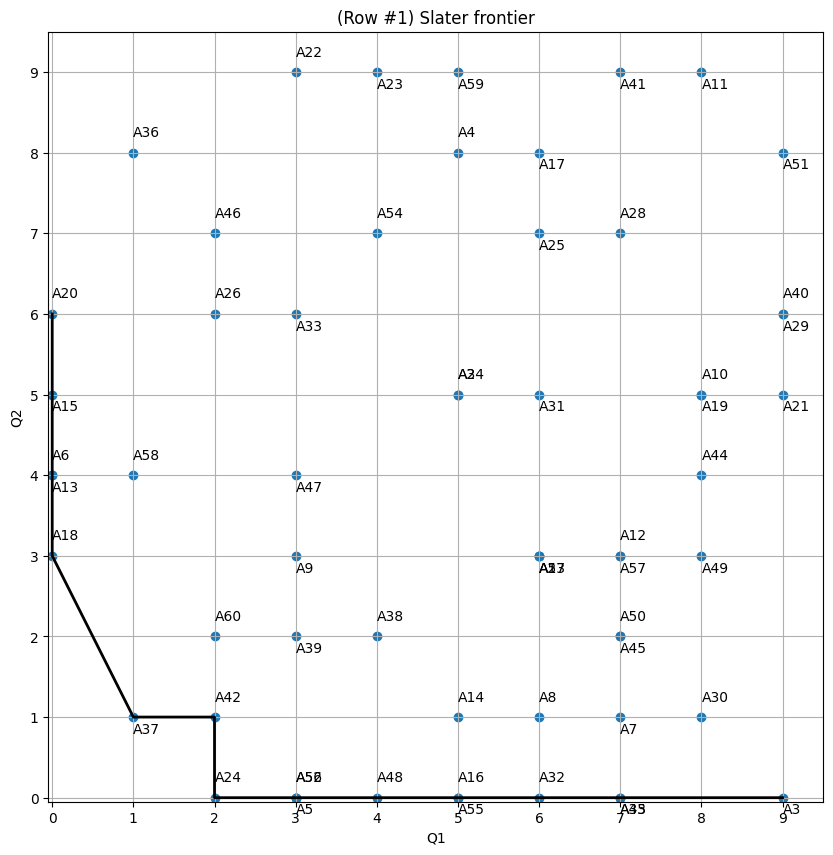

In [452]:
solve_task('original-long.csv', True)